In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import tensorflow_datasets as tfds

import numpy as np

import matplotlib.pyplot as plt

from rec.models.resnet_vae import BidirectionalResNetVAE
from rec.models.custom_modules import ReparameterizedConv2D, ReparameterizedConv2DTranspose
from rec.models.pixel_cnn import PixelCNNResidualBlock

In [2]:
# Taken from https://github.com/tensorflow/tensorflow/issues/31135#issuecomment-516526113
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

In [3]:
!ls ../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/

checkpoint		     ckpt-36.index
ckpt-35.data-00000-of-00002  ckpt-37.data-00000-of-00002
ckpt-35.data-00001-of-00002  ckpt-37.data-00001-of-00002
ckpt-35.index		     ckpt-37.index
ckpt-36.data-00000-of-00002  logs
ckpt-36.data-00001-of-00002


In [4]:
model_save_dir = "../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/"

In [5]:
model = BidirectionalResNetVAE(use_iaf=False,
                               num_res_blocks=24,
                               deterministic_filters=160,
                               stochastic_filters=32)

model(tf.zeros((1, 32, 32, 3)))

# -------------------------------------------------------------------------
# Create Checkpoints
# -------------------------------------------------------------------------
ckpt = tf.train.Checkpoint(model=model)

manager = tf.train.CheckpointManager(ckpt, model_save_dir, max_to_keep=3)

# Restore previous session
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print(f"Restored model from {manager.latest_checkpoint}")
else:
    print("Initializing model from scratch.")

Restored model from ../../../models/relative-entropy-coding/imagenet32/resnet_vae/gaussian/blocks_24/beta_1.000_lamb_0.100/ckpt-37


In [10]:
ds = tfds.load("cifar10", data_dir="/scratch/gf332/datasets/cifar10")["train"]
ds = ds.map(lambda x: tf.clip_by_value((tf.cast(x["image"], tf.float32) + 0.5) / 256., 0.0, 1.0) - 0.5)

In [11]:
len({"a":1})

1

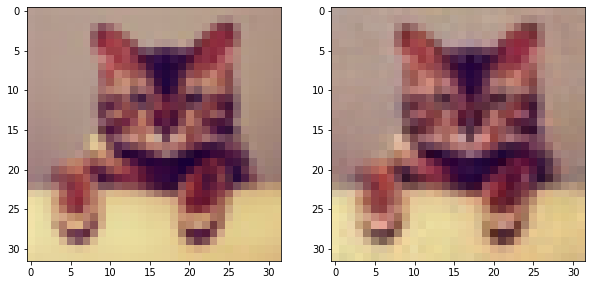

In [11]:
for img in ds.take(1):
    res = model(img[None, ...])
    
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img + 0.5)
    
    plt.subplot(122)
    plt.imshow(res[0, ...])

In [8]:
#tf.nn.moments(model.residual_blocks[0].infer_posterior_loc_head.kernel_weights, [0, 1, 3])
tf.reduce_min(model._generative_base)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.016166061>

In [18]:
snake_flatten = lambda l: [f"_{item}" for sublist in l for item in sublist]

def print_dict(d):
    
    items = []
    
    for k, v in d.items():
        items.append(k)
        items.append(f"{v:.4f}" if type(v) == float else f"{v}")
        
    return '_'.join(items)

print_dict({"lo": True, "haha": 123, "beb": np.pi})

'lo_True_haha_123_beb_3.1416'

In [80]:
mu_x = 1.
mu_y = -2.5

scale_x = 1.
scale_y = 2.

x_samps = tf.random.normal(mean=mu_x, stddev=scale_x, shape=(100000,))
y_samps = tf.random.normal(mean=mu_y, stddev=scale_y, shape=(100000,))

mu_z = mu_x + mu_y
z_samps = x_samps + y_samps

emp_mu_x = tf.reduce_mean(x_samps)
emp_mu_y = tf.reduce_mean(y_samps)
emp_mu_z = tf.reduce_mean(z_samps)

cov_xz = mu_x**2 + scale_x**2 - mu_x * (mu_x + mu_y) + mu_x * mu_y
print(cov_xz)

emp_cov_xz = tf.reduce_mean(z_samps * x_samps) - emp_mu_x * emp_mu_z
print(emp_cov_xz)

1.0
tf.Tensor(1.011839, shape=(), dtype=float32)


In [77]:
tf.reduce_mean(x_samps * x_samps) + tf.reduce_mean(x_samps * y_samps)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.49188495>

In [78]:
tf.reduce_mean(x_samps * y_samps)

<tf.Tensor: shape=(), dtype=float32, numpy=-2.50434>

In [79]:
mu_x * mu_y

-2.5